In [1]:
from ophyd import Device, EpicsMotor, EpicsSignal, EpicsSignalRO
from ophyd import Component as Cpt
import time
import pandas as pd
import numpy as np
from ophyd.sim import det4, noisy_det, motor  # simulated detector, motor
import h5py
from datetime import datetime

import bluesky.plan_stubs as bps
from bluesky.plans import count

import matplotlib.pyplot as plt
%matplotlib widget
#%matplotlib inline
#%matplotlib notebook

import glob

In [2]:
from bluesky import RunEngine
import bluesky.plan_stubs as bps
from bluesky.plans import count, scan
RE = RunEngine({})

In [3]:
## Prepare Live Visualization
from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

# Make plots update live while scans run.
# from bluesky.utils import install_kicker
# install_kicker()
#%matplotlib notebook
#from bluesky.utils import install_nb_kicker
#install_nb_kicker()


## Prepare Data Storage
from databroker import Broker
db = Broker.named('xpd')

# Insert all metadata/data captured into db.
RE.subscribe(db.insert)


## Add a Progress Bar
from bluesky.utils import ProgressBarManager
RE.waiting_hook = ProgressBarManager()


OBJECT CACHE: Will use up to 40_490_850_508 bytes (15% of total physical RAM)
INFO:tiled.server.object_cache:Will use up to 40_490_850_508 bytes (15% of total physical RAM)


In [4]:
RE(count([det4], num=1))



Transient Scan ID: 1     Time: 2022-10-28 16:26:38
Persistent Unique Scan ID: '1591d097-5c22-4697-9bdc-9228fce75d2f'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |       det4 |
+-----------+------------+------------+
|         1 | 16:26:38.6 |      1.000 |
+-----------+------------+------------+
generator count ['1591d097'] (scan num: 1)





('1591d097-5c22-4697-9bdc-9228fce75d2f',)

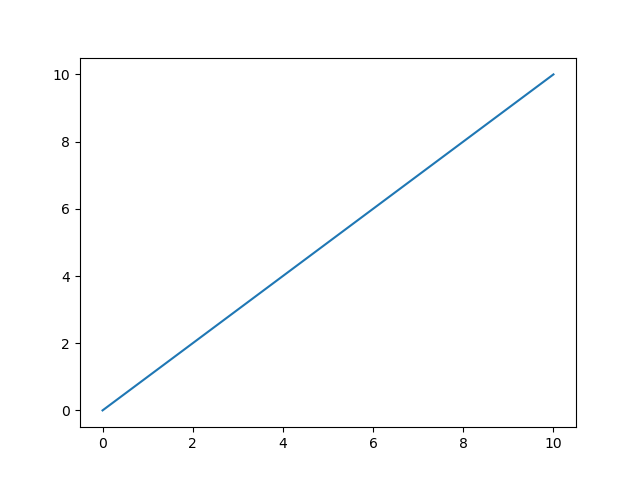

In [5]:
plt.figure()
plt.plot(np.arange(0,11),np.arange(0,11))

In [18]:
db[-1].table()

,det4,time
seq_num,,
1,1.0,2022-10-28 00:17:14.089330176
2,1.0,2022-10-28 00:17:14.100317184
3,1.0,2022-10-28 00:17:14.109317120
4,1.0,2022-10-28 00:17:14.118919168
5,1.0,2022-10-28 00:17:14.128654592


In [120]:
def reset_pumps(pump_list, clear=True, update = '.2 second'):
    for pump in pump_list:
        pump.initialize_pump(clear=clear, update = update)
        pump.infuse_rate_unit.put('ul/min', wait=True)
        pump.infuse_rate.put(100, wait=True)
        pump.withdraw_rate_unit.put('ul/min', wait=True)
        pump.withdraw_rate.put(100, wait=True)
        pump.target_vol_unit.put('ml', wait=True)
        pump.target_vol.put(20, wait=True)


def show_pump_status(syringe_list, pump_list, precursor_list, wait=False):
    for input_size, pump, precursor in zip(syringe_list, pump_list, precursor_list):
        print('Name: ' + f'{pump.name}')
        print('Precursor: ' + f'{precursor}')
        pump.check_pump_condition(input_size, wait=wait)
        print('\n')
        

def set_group_infuse(syringe_list, pump_list, target_vol_list=['50 ml', '50 ml'], rate_list = ['100 ul/min', '100 ul/min']):
    for i, j, k, l in zip(pump_list, target_vol_list, infuse_rate_list, syringe_list):
        vol = float(j.split(' ')[0])
        vol_unit = j.split(' ')[1]
        rate = float(k.split(' ')[0])
        rate_unit = k.split(' ')[1]        
        yield from i.set_infuse(l, target_vol = vol, target_unit = vol_unit, infuse_rate = rate, infuse_unit = rate_unit)
        
def set_group_withdraw(syringe_list, pump_list, target_vol_list=['50 ml', '50 ml'], rate_list = ['100 ul/min', '100 ul/min']):
    for i, j, k, l in zip(pump_list, target_vol_list, rate_list, syringe_list):
        vol = float(j.split(' ')[0])
        vol_unit = j.split(' ')[1]
        rate = float(k.split(' ')[0])
        rate_unit = k.split(' ')[1]        
        yield from i.set_withdraw(l, target_vol = vol, target_unit = vol_unit, withdraw_rate = rate, withdraw_unit = rate_unit)



In [121]:
## Available pump list : [dds1_p1, dds1_p2, dds2_p1, dds2_p2, ultra1, ultra2]
pump_list = [dds1_p1, dds1_p2, ultra2]
syringe_list = [50, 50, 100]
target_vol_list = ['18 ml', '49 ml', '88 ml']
infuse_rate_list = ['88 ul/min', '69 ul/min', '6 ml/min']
precursor_list = ['CsPb 30 mM', 'TetraBr 30 mM', 'Tol+OA']

In [104]:
reset_pumps(pump_list)

In [105]:
show_pump_status(syringe_list, pump_list, precursor_list)

Name: DDS1_p1
Precursor: CsPb 30 mM
Syringe Volume: 50 mL steel syringe
Pump Stauts: Idle
Cmmunication: Enabled
Target Volume: 20.0 ml
Infuse rate: 100.0 ul/min
Withdraw rate: 100.0 ul/min
Infused volume: 0.0 ul
Withdrawn volume: 0.0 ul


Name: DDS1_p2
Precursor: TetraBr 30 mM
Syringe Volume: 50 mL steel syringe
Pump Stauts: Idle
Cmmunication: Enabled
Target Volume: 20.0 ml
Infuse rate: 100.0 ul/min
Withdraw rate: 100.0 ul/min
Infused volume: 0.0 ul
Withdrawn volume: 0.0 ul


Name: Pump_Ultra2
Precursor: Tol+OA
(Input size doens't match the reading diameter. Use the input size.)
Syringe Volume: 100 mL steel syringe
Pump Stauts: Idle
Cmmunication: Enabled @ .2 second
Target Volume: 20 ml
Infuse rate: 100.0 ul/min
Withdraw rate: 100.0 ul/min
Infused volume: 0.0 ul
Withdrawn volume: 0.0 ul




In [122]:
RE(set_group_infuse(syringe_list, pump_list, target_vol_list=target_vol_list, rate_list=infuse_rate_list))

()

In [124]:
show_pump_status(syringe_list, pump_list, precursor_list)

Name: DDS1_p1
Precursor: CsPb 30 mM
Syringe Volume: 50 mL steel syringe
Pump Stauts: Idle
Cmmunication: Enabled
Target Volume: 18.0 ml
Infuse rate: 88.0 ul/min
Withdraw rate: 100.0 ul/min
Infused volume: 0.0 ul
Withdrawn volume: 0.0 ul


Name: DDS1_p2
Precursor: TetraBr 30 mM
Syringe Volume: 50 mL steel syringe
Pump Stauts: Idle
Cmmunication: Enabled
Target Volume: 49.0 ml
Infuse rate: 69.0 ul/min
Withdraw rate: 100.0 ul/min
Infused volume: 0.0 ul
Withdrawn volume: 0.0 ul


Name: Pump_Ultra2
Precursor: Tol+OA
(Input size doens't match the reading diameter. Use the input size.)
Syringe Volume: 100 mL steel syringe
Pump Stauts: Idle
Cmmunication: Enabled @ .2 second
Target Volume: 88 ml
Infuse rate: 6.0 ml/min
Withdraw rate: 100.0 ul/min
Infused volume: 0.0 ul
Withdrawn volume: 0.0 ul




In [ ]:
RE(dds1_p1.infuse_pump())

In [ ]:
qepro.set_temp(-5)

In [ ]:
qepro.setup_collection?

In [ ]:
qepro.setup_collection(integration_time=100, num_spectra_to_average=10, electric_dark_correction=True)

In [ ]:
shutter_close()
qepro.get_dark_frame()
shutter_open()

In [ ]:
qepro.get_reference_frame()

In [ ]:
qepro.trigger()

In [ ]:
qepro.plot_spectra()

In [ ]:
def h5_rate_spectra(h5_path, h5_name, pump_list, precursor_list, absor=qepro, xray=det4, delay=None):

    fout = h5_path + h5_name
    t_q = list(absor.read().items())[0][1]['timestamp']
    dt = datetime.fromtimestamp(t_q)

    
    with h5py.File(fout, 'w') as hf:
        hf.create_dataset('Time_QEPro', data=[f'{dt.year}{dt.month:02d}{dt.day:02d}', f'{dt.hour:02d}{dt.minute:02d}{dt.second:02d}'])
        hf.create_dataset('Wavelength', data=absor.x_axis.get())
        hf.create_dataset('Dark', data=absor.dark.get())
        if absor.spectrum_type.get(as_string=True) == 'Absorbtion':           
            hf.create_dataset('Reference', data=absor.reference.get())
            hf.create_dataset('Sample_UV', data=absor.sample.get())
            hf.create_dataset('Abosrbance', data=absor.output.get())
        else:
            hf.create_dataset('Sample_PL', data=absor.sample.get())
            hf.create_dataset('PL', data=absor.output.get())            
        for pump, precursor in zip(pump_list, precursor_list):
            hf.create_dataset(pump.name, data=[f'{precursor}', f'{pump.read_infuse_rate.get()}', 
                                               pump.read_infuse_rate_unit.get()])      
    print(f'{fout} is saved.')
    hf.close()

    

    
def csv_rate_spectra(csv_path, csv_name, pump_list, precursor_list, absor=qepro, xray=det4, delay=None):

    fout = csv_path + csv_name
    t_q = list(absor.read().items())[0][1]['timestamp']
    dt = datetime.fromtimestamp(t_q)
    
    with open(fout, 'w') as fp:
        for pump, precursor in zip(pump_list, precursor_list):
            fp.write(f'{pump.name},{precursor},{pump.read_infuse_rate.get()},{pump.read_infuse_rate_unit.get()}\n')        
        
        fp.write(f'Time_QEPro,{dt.year}{dt.month:02d}{dt.day:02d},{dt.hour:02d}{dt.minute:02d}{dt.second:02d}\n')
        x_axis_data = absor.x_axis.get()
        output_data = absor.output.get()
        sample_data = absor.sample.get()
        dark_data = absor.dark.get()
        reference_data = absor.reference.get()
        if absor.spectrum_type.get(as_string=True) == 'Absorbtion':
            fp.write('Energy,Dark,Reference,Sample,Absorbance\n')
        else:
            fp.write('Energy,Dark,Raw Sample,PL\n')

        for i in range(len(output_data)):
            if absor.spectrum_type.get(as_string=True) == 'Absorbtion':
                fp.write(f'{x_axis_data[i]},{dark_data[i]},{reference_data[i]},{sample_data[i]},{output_data[i]}\n')
            else:
                fp.write(f'{x_axis_data[i]},{dark_data[i]},{sample_data[i]},{output_data[i]}\n')

        print('Done.')


In [ ]:
h5_path = '/nsls2/users/clin1/Documents/Cheng-Hung/temp/'
h5_name = '20220912_test6.h5'
h5_rate_spectra(h5_path, h5_name, pump_list, precursor_list, absor=qepro)

In [ ]:
csv_path = '/nsls2/users/clin1/Documents/Cheng-Hung/temp/'
csv_name = '20220912_test3.csv'
csv_rate_spectra(csv_path, csv_name, pump_list, precursor_list, absor=qepro)

In [ ]:
f = '/nsls2/users/clin1/Documents/Cheng-Hung/temp/20220912_test2.csv'
df = pd.read_csv(f, skiprows=3)
df

In [ ]:
b = list(dds1_p1.read().items())
b[0][1]['timestamp']
dt = datetime.fromtimestamp(b[0][1]['timestamp'])
dt?

In [ ]:
dds1_p1.name

In [ ]:
for pump, precursor in zip(pump_list, precursor_list):
    print(pump.name)
    data=[f'{precursor}', pump.read_infuse_rate.get(), pump.read_infuse_rate_unit.get()]
    print(data)